In [4]:
import pandas as pd

tech_indincators = pd.read_pickle('/root/blocksnet/tests/data/tep.pickle').fillna(0)
social_indicators = pd.read_pickle('/root/blocksnet/tests/data/indicators.pickle').fillna(0)

# Предсказание СЭР

In [16]:
from blocksnet.machine_learning.regression import SocialRegressor

ir = SocialRegressor(model_path='/root/blocksnet/tests/data/social_regressor_model.pkl')

Model loaded from: /root/blocksnet/tests/data/social_regressor_model.pkl


In [17]:
X_train, X_test, y_train, y_test = ir.get_train_data(technical_indicators=tech_indincators, social_indicators=social_indicators)

2025-05-20 16:12:44.266 | INFO     | blocksnet.machine_learning.regression.social.core:_initialize_features:47 - Fitting scaler to data
2025-05-20 16:12:44.280 | INFO     | blocksnet.machine_learning.regression.social.core:_initialize_features:47 - Fitting scaler to data


In [18]:
preds, mse = ir.train(x_train=X_train, y_train=y_train)

In [19]:
x_sample = X_test.iloc[[0]]

df_result = ir.predict_with_intervals(
    x_single=x_sample,
    x_train=X_train,
    y_train=y_train,
    bootstrap_loop_count=3
)
df_result

Running bootstrap (3 iterations)...


Bootstrapping: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


,Prediction,Prediction Interval,Confidence Interval
Численность населения,2.747070e-02,"[0.0269, 0.0281]","[0.0269, 0.0281]"
Площадь территории,2.166938e-02,"[0.0208, 0.0227]","[0.0208, 0.0227]"
Средняя доступность до федеральных транспортных магистралей,1.770760e-07,"[0.0000, 0.0000]","[0.0000, 0.0000]"
Средняя доступность до центра региона,1.572883e-01,"[0.1981, 0.2752]","[0.1981, 0.2752]"
Протяженность дорог регионального значения,1.151154e-01,"[0.0674, 0.1246]","[0.0674, 0.1246]"
Протяженность дорог местного значения,1.100756e-01,"[0.1051, 0.1166]","[0.1051, 0.1166]"
Количество остановок общественного транспорта,1.686224e-01,"[0.0985, 0.1294]","[0.0985, 0.1294]"
Средняя доступность автозаправочных станций,2.181907e-01,"[0.1550, 0.2331]","[0.1550, 0.2331]"
Средняя доступность международных аэропортов,2.572846e-01,"[0.2790, 0.3657]","[0.2790, 0.3657]"
Средняя доступность аэропортов местного значения,2.453283e-01,"[0.1891, 0.3562]","[0.1891, 0.3562]"


## Получаем доверительные интервалы с помощью бутстрапинга

Чем больше значение B (количество ресемплов), тем точнее предсказания интервалов

In [20]:
mean_preds, ci_lower, ci_upper, pi_lower, pi_upper = ir.compute_bootstrap_intervals(x_train=X_train,
                                                                                    y_train=y_train,
                                                                                    x_test=X_test,
                                                                                    bootstrap_loop_count=3)

Running bootstrap (3 iterations)...


Bootstrapping: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


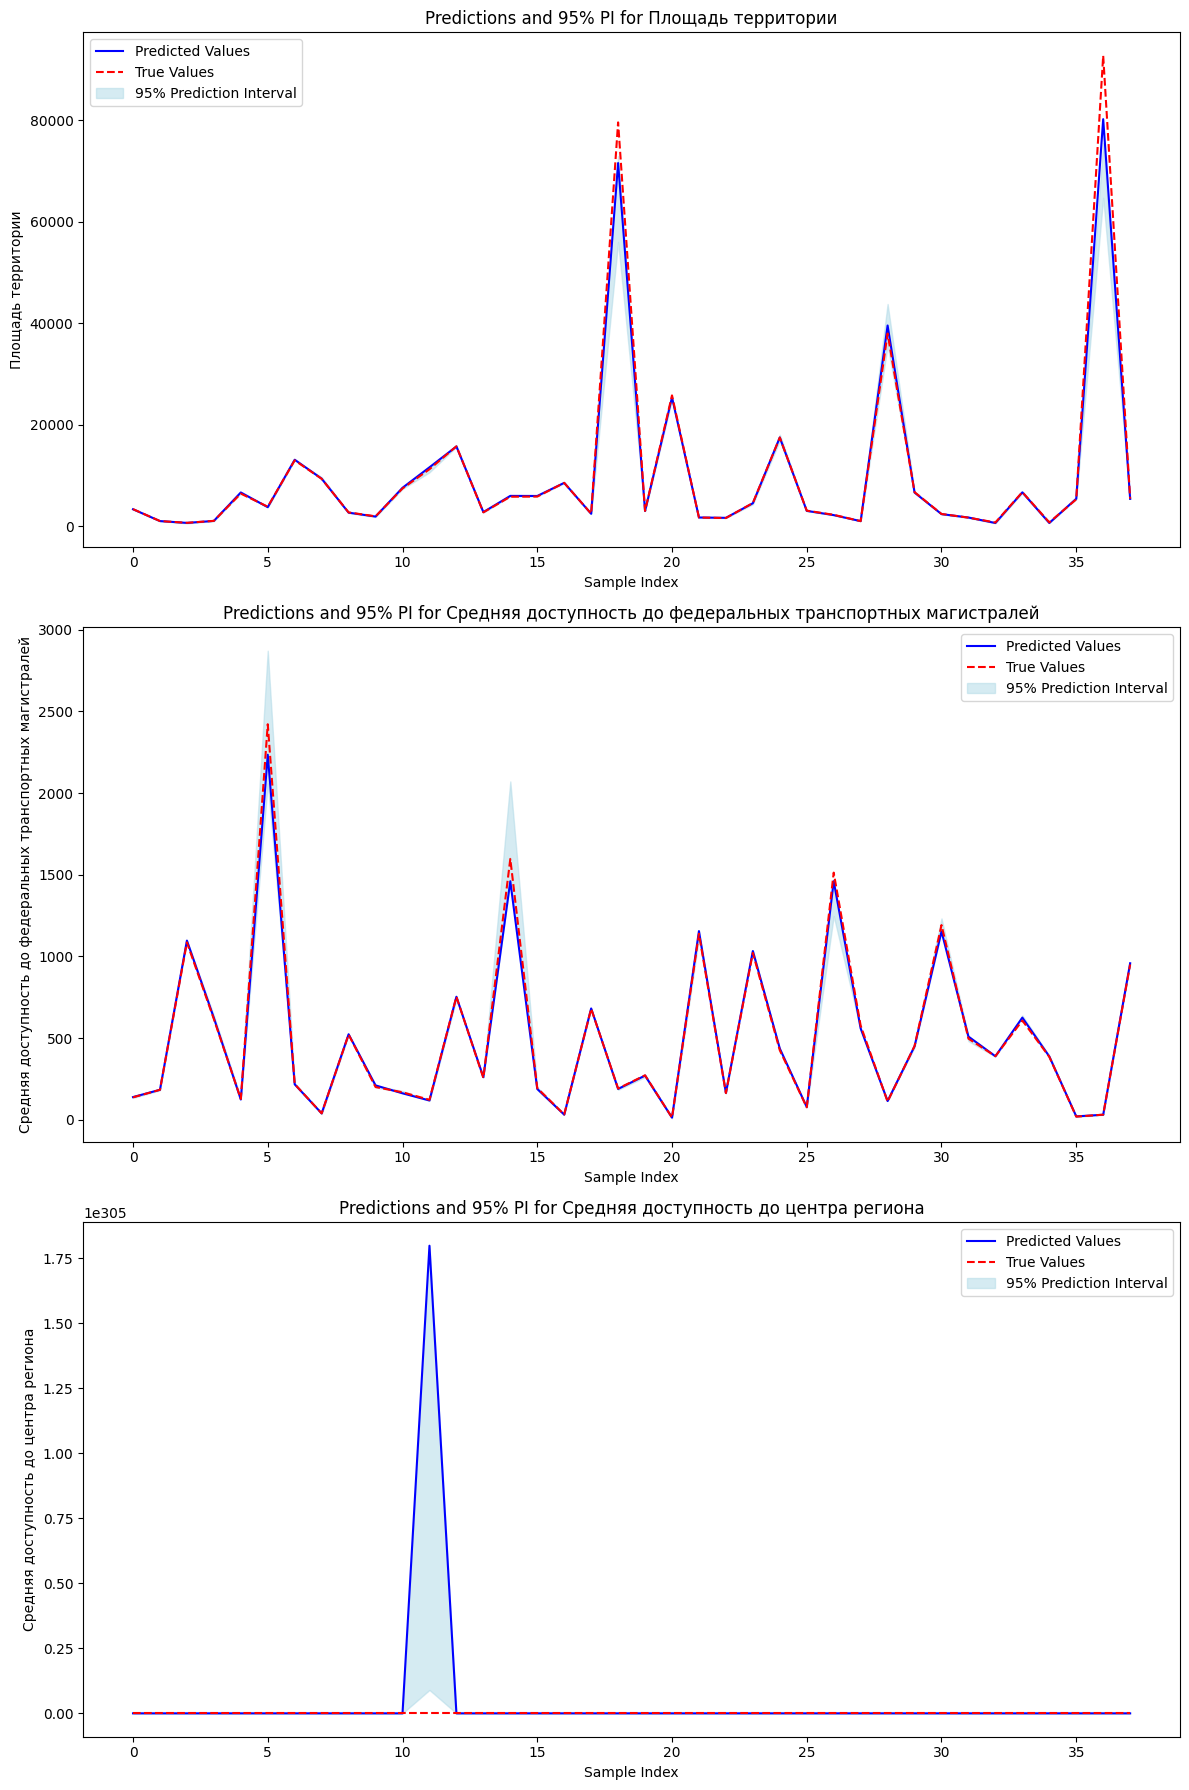

In [21]:
# в column_names можно передать 
ir.plot_prediction_intervals(mean_preds, pi_lower, pi_upper, y_test, column_names=y_train.columns.tolist()[1:4], inverse_transform=True)

## Визуализация важности фичей

Общая средняя важность признаков:
                  mean_importance
site_area                0.218358
living_area              0.123421
non_living_area          0.118474
population               0.107652
build_floor_area         0.105754
recreation               0.091068
residential              0.078736
footprint_area           0.061074
industrial               0.056516
special                  0.038947


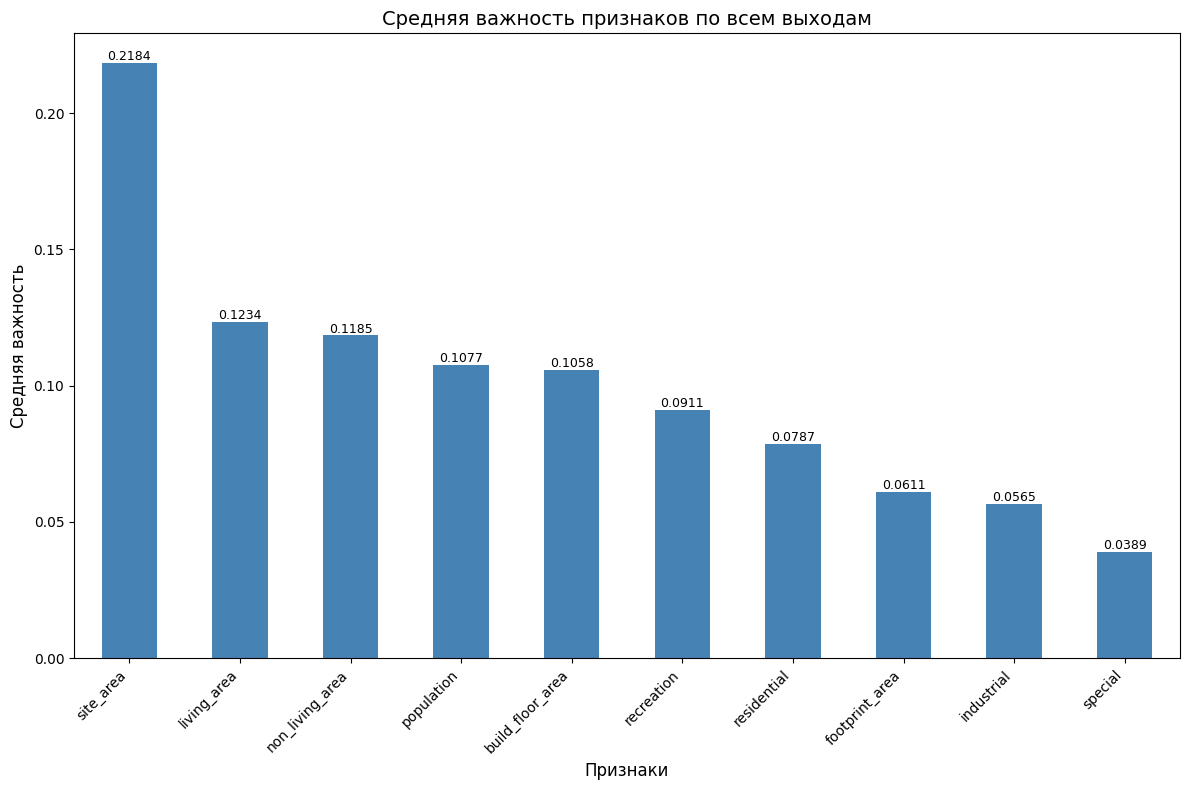

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Получение важности признаков
feature_importances = []
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"feature_{i}" for i in range(X_train.shape[1])]
output_names = y_train.columns if hasattr(y_train, 'columns') else [f"target_{i}" for i in range(y_train.shape[1])]

for i, estimator in enumerate(ir.model.estimators_):
    # Для каждого отдельного регрессора
    importances = estimator.feature_importances_
    feature_importances.append(importances)
    
    # Вывод важности для каждого выхода
    target_name = output_names[i]


feature_importance_df = pd.DataFrame(
    np.array(feature_importances).T,
    index=feature_names,
    columns=output_names
)

# Средняя важность по всем выходам
feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
feature_importance_df = feature_importance_df.sort_values('mean_importance', ascending=False)

print("Общая средняя важность признаков:")
print(feature_importance_df[['mean_importance']])

# Визуализация средней важности признаков
plt.figure(figsize=(12, 8))
ax = feature_importance_df['mean_importance'].plot(kind='bar', color='steelblue')
plt.title('Средняя важность признаков по всем выходам', fontsize=14)
plt.ylabel('Средняя важность', fontsize=12)
plt.xlabel('Признаки', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Добавляем значения над столбцами
for i, v in enumerate(feature_importance_df['mean_importance']):
    ax.text(i, v + 0.001, f'{v:.4f}', ha='center', fontsize=9)

plt.show()

## Ошибка на разных таргетах

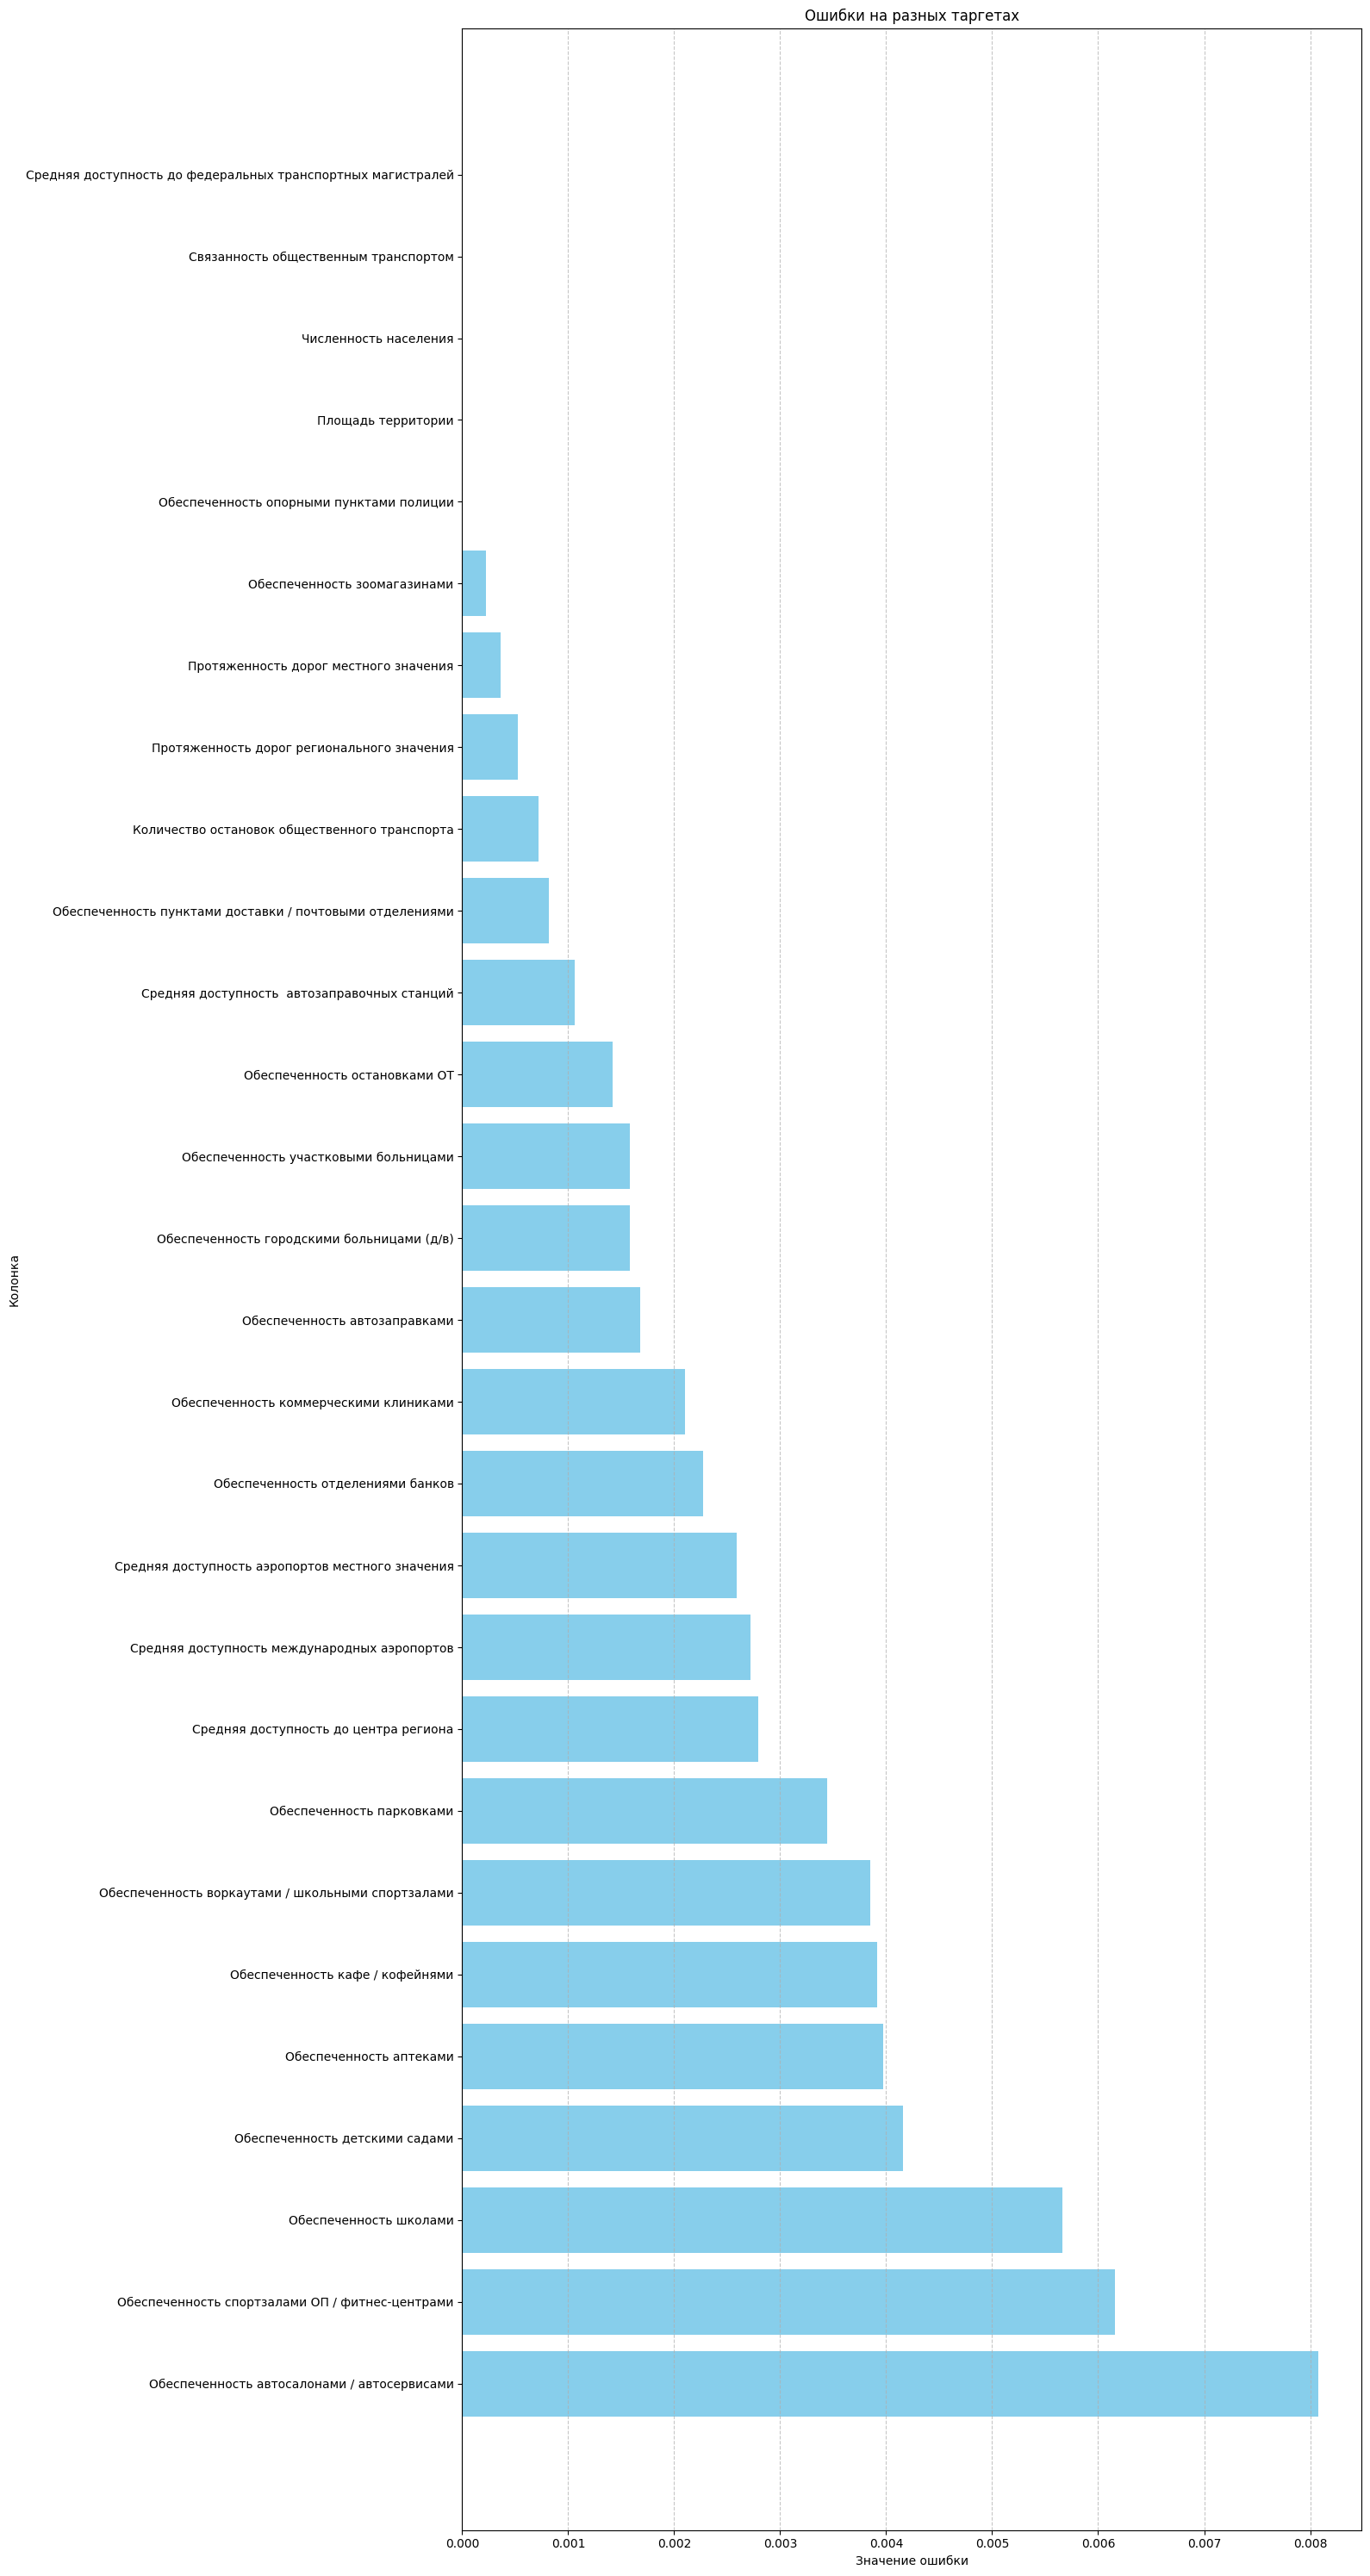

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Предположим, что mse — список значений ошибок, а Y.columns — список названий колонок
# Сортируем по убыванию
sorted_indices = np.argsort(mse)[::-1]
sorted_mse = np.array(mse)[sorted_indices]
sorted_columns = np.array(y_train.columns)[sorted_indices]

# Построение горизонтальной гистограммы
plt.figure(figsize=(16, 30))
plt.barh(sorted_columns, sorted_mse, color='skyblue')

# Добавим подписи и заголовок
plt.ylabel('Колонка')
plt.xlabel('Значение ошибки')
plt.title('Ошибки на разных таргетах')

# Сетка и отображение
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Предсказание LIME

Показывает влияние фичей на конкретное предсказание

Mean Squared Error: 0.070
Predicted value: 0.9496701004025547
Real value: 1.0
Explanation:
[('0.01 < site_area <= 0.05', 0.10085652353683702), ('recreation <= 0.00', 0.04585556403246259), ('0.02 < population <= 0.04', 0.04302802354666921), ('0.13 < residential <= 0.23', 0.029314574550491072), ('0.07 < footprint_area <= 0.13', 0.020370904802657432), ('0.00 < living_area <= 0.01', 0.018037321148712104), ('0.03 < build_floor_area <= 0.06', -0.01227918354553109), ('0.00 < special <= 0.00', -0.009165143560643664), ('0.06 < non_living_area <= 0.12', 0.0028529812248362287), ('0.03 < industrial <= 0.10', 0.0022316926968332044)]


/root/blocksnet/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


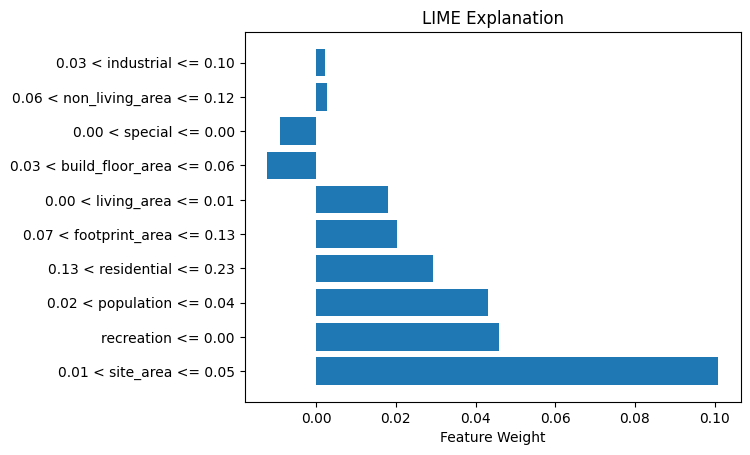

In [13]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lime.lime_tabular import LimeTabularExplainer


y_train = y_train.fillna(0)
# Базовая модель GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Обучение модели
gbr.fit(X_train, y_train['Обеспеченность аптеками'])

# Пример предсказания
y_pred = gbr.predict(X_test)

# Оценка качества
mse = mean_squared_error(y_test['Обеспеченность аптеками'], y_pred)
print(f'Mean Squared Error: {mse:.3f}')

# Создание LIME объяснителя для табличных данных
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Преобразуем DataFrame в numpy массив
    feature_names=X_train.columns,  # Указываем имена признаков
    class_names=[str(i) for i in range(y_train.shape[1])],  # Если многовыходная регрессия
    mode='regression',  # Тип задачи: регрессия
    random_state=42
)

# Выбираем одно наблюдение для интерпретации (например, первое из теста)
i = 0
instance = X_test.iloc[i].values.reshape(1, -1)

# Получаем объяснение для выбранного примера
explanation = explainer.explain_instance(instance[0], gbr.predict)

# Если нужно просто вывести данные:
print("Predicted value:", y_pred[i])
print('Real value:', y_test['Обеспеченность аптеками'].iloc[0])
print("Explanation:")
print(explanation.as_list())


import matplotlib.pyplot as plt

# Получаем объяснение как список
explanation_list = explanation.as_list()

# Разбиваем объяснение на признаки и веса
features, weights = zip(*explanation_list)

# Строим график
plt.barh(features, weights)
plt.xlabel("Feature Weight")
plt.title("LIME Explanation")
plt.show()